In [ ]:
import numpy as np
import pandas as pd

In [ ]:
TRAIN_DATA_PATH = '/kaggle/input/train-dataset/train/train.csv'
EVAL_DATA_PATH = '/kaggle/input/eval-dataset/dev/dev.csv'
TEST_DATA_PATH = '/kaggle/input/test-dataset/test/test.csv'
TEST_LABELS_PATH = '/kaggle/input/test-with-labels/test_with_labels/test_with_labels.csv'
# Load the training data
train_data = pd.read_csv(TRAIN_DATA_PATH)
eval_data = pd.read_csv(EVAL_DATA_PATH)
test_data = pd.read_csv(TEST_DATA_PATH)
test_labels=pd.read_csv(TEST_LABELS_PATH)

In [ ]:
train_label_counts = train_data['labels'].value_counts()
eval_label_counts = eval_data['labels'].value_counts()
test_label_counts=test_labels['labels'].value_counts()

# Display the counts
print("Training Data Label Distribution:")
print(train_label_counts)

print("\nValidation Data Label Distribution:")
print(eval_label_counts)

print("\nTest Data Label Distribution:")
print(test_label_counts)

Training Data Label Distribution:
labels
0    381
1    259
Name: count, dtype: int64

Validation Data Label Distribution:
labels
0    97
1    63
Name: count, dtype: int64

Test Data Label Distribution:
labels
0    122
1     78
Name: count, dtype: int64


In [ ]:
train_data.shape

(640, 3)

In [ ]:
eval_data.shape


(160, 3)

In [ ]:
test_data.shape

(200, 2)

In [ ]:
train_data.head()

,image_id,labels,transcriptions
0,888,0,\nഈ ചാടി ഓടി നടക്കണ മനുഷ്യനാണോടാ നിങ്ങളിത്രേം ...
1,554,1,മലയാള സിനിമയുടെ ഭാവി വടറാണി ഇവൾ തന്നെ നല്ല കുഴ...
2,556,1,ഒന്ന് പെറ്റത് ആണെങ്കിലും .. മുലയും വയറും ചാടിയ...
3,484,1,ഓൺലൈൻ പരിചയപ്പെട്ടവനെ കളി തരാമെന്ന് പറഞ്ഞു അപ്...
4,370,0,കാമുകിയും അൺലിമിറ്റഡ് നെറ്റ് ഓഫറുംഉള്ള പയ്യന്റ...


In [ ]:
pip install transformers tensorflow


Note: you may need to restart the kernel to use updated packages.


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report

def load_and_preprocess_data(csv_path):
    data = pd.read_csv(csv_path)
    texts = data['transcriptions'].tolist()
    labels = data['labels'].tolist()
    return texts, labels

# Paths for your dataset
TRAIN_CSV_PATH = '/kaggle/input/train-dataset/train/train.csv'
EVAL_CSV_PATH = '/kaggle/input/eval-dataset/dev/dev.csv'
TEST_CSV_PATH = '/kaggle/input/test-with-labels/test_with_labels/test_with_labels.csv'

# Load data
train_texts, train_labels = load_and_preprocess_data(TRAIN_CSV_PATH)
eval_texts, eval_labels = load_and_preprocess_data(EVAL_CSV_PATH)
test_texts, test_labels = load_and_preprocess_data(TEST_CSV_PATH)

# Merge training and evaluation data
merged_texts = train_texts + eval_texts
merged_labels = train_labels + eval_labels

# Initialize tokenizer
text_tokenizer = AutoTokenizer.from_pretrained(
    "ai4bharat/indic-bert",
    model_max_length=128,
    use_fast=True
)

# Load the model - removed from_pt parameter
text_model = AutoModelForSequenceClassification.from_pretrained(
    "ai4bharat/indic-bert",
    num_labels=2
)

def tokenize_texts(texts, tokenizer, max_length=128):
    return tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )

# Tokenize the data
merged_encodings = tokenize_texts(merged_texts, text_tokenizer)
test_encodings = tokenize_texts(test_texts, text_tokenizer)

# Create datasets
train_labels_tensor = torch.tensor(merged_labels)
test_labels_tensor = torch.tensor(test_labels)

train_dataset = TensorDataset(
    merged_encodings['input_ids'],
    merged_encodings['attention_mask'],
    train_labels_tensor
)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Optimizer
optimizer = torch.optim.AdamW(text_model.parameters(), lr=5e-5)

# Training loop
def train_model(model, dataloader, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in dataloader:
            input_ids, attention_mask, labels = batch

            optimizer.zero_grad()
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss / len(dataloader)}")

# Evaluation function
def evaluate_model(model, encodings, labels_tensor):
    model.eval()
    with torch.no_grad():
        outputs = model(
            input_ids=encodings['input_ids'],
            attention_mask=encodings['attention_mask']
        )
        logits = outputs.logits
        predicted_labels = torch.argmax(logits, axis=1)
        return predicted_labels

# Train the model
train_model(text_model, train_dataloader, optimizer, epochs=5)

# Evaluate on test data
predicted_labels = evaluate_model(text_model, test_encodings, test_labels_tensor)

# Print classification report
print("\nClassification Report:\n")
print(classification_report(
    test_labels_tensor,
    predicted_labels.numpy(),
    target_names=["Non-Misogyny", "Misogyny"]
))

config.json:   0%|          | 0.00/507 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/5.65M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/135M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5 - Loss: 0.6650029933452606
Epoch 2/5 - Loss: 0.6112319225072861
Epoch 3/5 - Loss: 0.5618323558568954
Epoch 4/5 - Loss: 0.49354075491428373
Epoch 5/5 - Loss: 0.4111149963736534

Classification Report:

              precision    recall  f1-score   support

Non-Misogyny       0.86      0.68      0.76       122
    Misogyny       0.62      0.82      0.71        78

    accuracy                           0.73       200
   macro avg       0.74      0.75      0.73       200
weighted avg       0.76      0.73      0.74       200



Confusion Matrix:
 [[83 39]
 [14 64]]


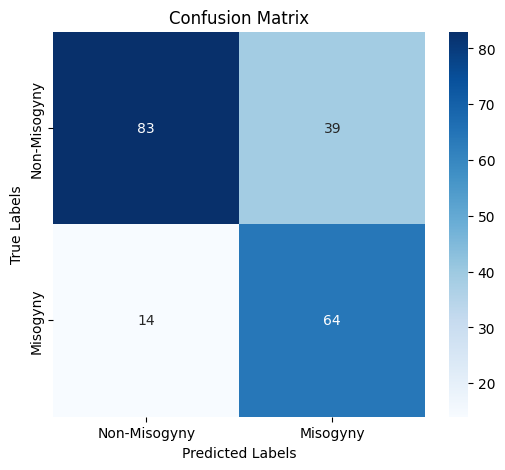

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_matrix = confusion_matrix(test_labels_tensor, predicted_labels.numpy())

# Print confusion matrix
print("Confusion Matrix:\n", conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Non-Misogyny", "Misogyny"], yticklabels=["Non-Misogyny", "Misogyny"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report
from tqdm import tqdm

def load_and_preprocess_data(csv_path):
    data = pd.read_csv(csv_path)
    texts = data['transcriptions'].tolist()
    labels = data['labels'].tolist()
    return texts, labels

# Paths for your dataset
TRAIN_CSV_PATH = '/kaggle/input/train-dataset/train/train.csv'
EVAL_CSV_PATH = '/kaggle/input/eval-dataset/dev/dev.csv'
TEST_CSV_PATH = '/kaggle/input/test-with-labels/test_with_labels/test_with_labels.csv'

# Load data
train_texts, train_labels = load_and_preprocess_data(TRAIN_CSV_PATH)
eval_texts, eval_labels = load_and_preprocess_data(EVAL_CSV_PATH)
test_texts, test_labels = load_and_preprocess_data(TEST_CSV_PATH)

# Merge training and evaluation data
merged_texts = train_texts + eval_texts
merged_labels = train_labels + eval_labels

# Initialize tokenizer
text_tokenizer = AutoTokenizer.from_pretrained(
    "l3cube-pune/malayalam-bert",
    model_max_length=128,
    use_fast=True
)

# Custom classification model using l3cube-pune/malayalam-bert
class MalayalamBertClassifier(nn.Module):
    def __init__(self, num_labels=2):
        super().__init__()
        self.bert = AutoModel.from_pretrained("l3cube-pune/malayalam-bert")
        self.bert.resize_token_embeddings(len(text_tokenizer))
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]  # Take [CLS] token output
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)

        return {'loss': loss, 'logits': logits} if loss is not None else {'logits': logits}

# Initialize the custom model
text_model = MalayalamBertClassifier(num_labels=2)

def tokenize_texts(texts, tokenizer, max_length=128):
    return tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )

# Tokenize the data
merged_encodings = tokenize_texts(merged_texts, text_tokenizer)
test_encodings = tokenize_texts(test_texts, text_tokenizer)

# Create datasets
train_labels_tensor = torch.tensor(merged_labels)
test_labels_tensor = torch.tensor(test_labels)

train_dataset = TensorDataset(
    merged_encodings['input_ids'],
    merged_encodings['attention_mask'],
    train_labels_tensor
)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Optimizer
optimizer = torch.optim.AdamW(text_model.parameters(), lr=2e-5)

# Training loop with progress bar
def train_model(model, dataloader, optimizer, epochs):
    model.train()

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        progress_bar = tqdm(dataloader, desc="Training")
        total_loss = 0

        for batch in progress_bar:
            input_ids, attention_mask, labels = batch

            optimizer.zero_grad()
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs['loss']
            total_loss += loss.item()

            loss.backward()
            optimizer.step()

            # Update progress bar
            progress_bar.set_postfix({'loss': f"{loss.item():.4f}"})

        avg_loss = total_loss / len(dataloader)
        print(f"Average loss for epoch {epoch+1}: {avg_loss:.4f}")

# Evaluation function
def evaluate_model(model, encodings, labels_tensor):
    model.eval()
    with torch.no_grad():
        outputs = model(
            input_ids=encodings['input_ids'],
            attention_mask=encodings['attention_mask']
        )
        logits = outputs['logits']
        predicted_labels = torch.argmax(logits, axis=1)
        return predicted_labels

# Train the model for 5 epochs
print("Starting training...")
train_model(text_model, train_dataloader, optimizer, epochs=5)

# Evaluate on test data
print("\nEvaluating on test data...")
predicted_labels = evaluate_model(text_model, test_encodings, test_labels_tensor)

# Print classification report
print("\nClassification Report:\n")
print(classification_report(
    test_labels_tensor,
    predicted_labels.numpy(),
    target_names=["Non-Misogyny", "Misogyny"]
))

tokenizer_config.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/3.16M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/6.41M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/664 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/951M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at l3cube-pune/malayalam-bert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...

Epoch 1/5


Training: 100%|██████████| 25/25 [05:29<00:00, 13.20s/it, loss=0.6656]


Average loss for epoch 1: 0.6825

Epoch 2/5


Training: 100%|██████████| 25/25 [05:23<00:00, 12.95s/it, loss=0.6171]


Average loss for epoch 2: 0.6436

Epoch 3/5


Training: 100%|██████████| 25/25 [05:22<00:00, 12.91s/it, loss=0.5794]


Average loss for epoch 3: 0.6070

Epoch 4/5


Training: 100%|██████████| 25/25 [05:21<00:00, 12.85s/it, loss=0.5737]


Average loss for epoch 4: 0.5696

Epoch 5/5


Training: 100%|██████████| 25/25 [05:22<00:00, 12.91s/it, loss=0.5210]


Average loss for epoch 5: 0.5103

Evaluating on test data...

Classification Report:

              precision    recall  f1-score   support

Non-Misogyny       0.90      0.78      0.83       122
    Misogyny       0.71      0.86      0.78        78

    accuracy                           0.81       200
   macro avg       0.80      0.82      0.81       200
weighted avg       0.82      0.81      0.81       200



Confusion Matrix:
 [[95 27]
 [11 67]]


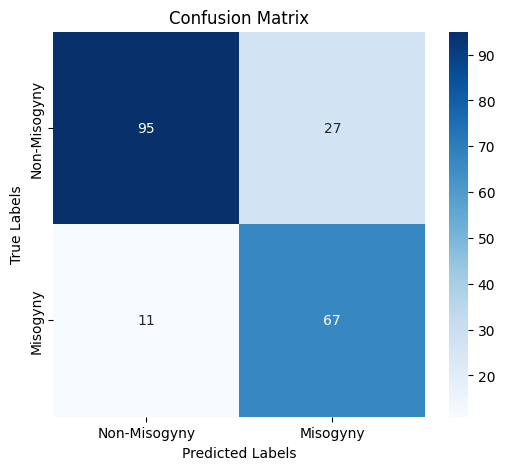

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_matrix = confusion_matrix(test_labels_tensor, predicted_labels.numpy())

# Print confusion matrix
print("Confusion Matrix:\n", conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Non-Misogyny", "Misogyny"], yticklabels=["Non-Misogyny", "Misogyny"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
